In [1]:
!pip install statsmodels
!pip install scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.base import clone
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.preprocessing import StandardScaler


1A) Reading files. 
Notes about reading files and changes
1. Data for each activity was stored as separate list of dataframes to simplify code, make it readable, and for easy split to test/train later in 1B. e.g., all bending csv files were read into list "bending1_dfs" and so on. 
2. Column 1 was renamed to "time" since it default read as "# Columns: time"
3. We add a column "activity" that stores which activity the data belongs to, so that when we later combine the dataframes into 1, we retain this info.
4. Dataset 4 in Bending2 had mixed delimiters: comma space in header and space delimiter in data with some trailing spaces.
   Thus, this was treated separately
5. 1st 4 rows were skipped as it did not contain relevant data
6. Some datasets had extra columns due to trailing spaces. Thus we used usecols=range(7) to ensure we only read the 1st 6 columns

In [2]:
pd.set_option("display.width", 200)
pd.set_option("display.max_columns", None)
# Read bending1 files: 7 csv files
bending1_dfs = [pd.read_csv(f"../data/arem/bending1/dataset{i}.csv", sep=',', skiprows=4) for i in range(1, 8)]
bending1_dfs = [df.rename(columns={df.columns[0]: "time"}) for df in bending1_dfs]
for df in bending1_dfs:
    df["activity"] = "bending1"

# Read bending2 (6 files) 
# dataset4.csv: Headers have comma delmiter, data has space delimiter. thus we read headers separately and data separately. 
bending2_dfs = []
for i in range(1, 7):
    file_path = f"../data/arem/bending2/dataset{i}.csv"
    if i == 4:
        # Read only the column names first.
        headers = pd.read_csv(file_path, sep=',', skiprows=4, nrows=1).columns.tolist()
        # Read the actual data using space separator and correct headers
        df = pd.read_csv(file_path, sep=r"\s+", skiprows=5, names=headers, engine="python")
    else:
        df = pd.read_csv(file_path, sep=',', skiprows=4, usecols=range(7))
    df.rename(columns={df.columns[0]: "time"}, inplace=True)
    df["activity"] = "bending2"
    bending2_dfs.append(df)

# Read cycling (15 files) using usecols to ensure column consistency
cycling_dfs = [pd.read_csv(f"../data/arem/cycling/dataset{i}.csv", sep=',', skiprows=4, usecols=range(7)) for i in range(1, 16)]
cycling_dfs = [df.rename(columns={df.columns[0]: "time"}) for df in cycling_dfs]
for df in cycling_dfs:
    df["activity"] = "cycling"


# Read lying, sitting, standing, walking (15 files)
lying_dfs = [pd.read_csv(f"../data/arem/lying/dataset{i}.csv", sep=',', skiprows=4, usecols=range(7)) for i in range(1, 16)]
lying_dfs = [df.rename(columns={df.columns[0]: "time"}) for df in lying_dfs]
for df in lying_dfs:
    df["activity"] = "lying"

sitting_dfs = [pd.read_csv(f"../data/arem/sitting/dataset{i}.csv", sep=',', skiprows=4, usecols=range(7)) for i in range(1, 16)]
sitting_dfs = [df.rename(columns={df.columns[0]: "time"}) for df in sitting_dfs]
for df in sitting_dfs:
    df["activity"] = "sitting"

standing_dfs = [pd.read_csv(f"../data/arem/standing/dataset{i}.csv", sep=',', skiprows=4, usecols=range(7)) for i in range(1, 16)]
standing_dfs = [df.rename(columns={df.columns[0]: "time"}) for df in standing_dfs]
for df in standing_dfs:
    df["activity"] = "standing"

walking_dfs = [pd.read_csv(f"../data/arem/walking/dataset{i}.csv", sep=',', skiprows=4, usecols=range(7)) for i in range(1, 16)]
walking_dfs = [df.rename(columns={df.columns[0]: "time"}) for df in walking_dfs]
for df in walking_dfs:
    df["activity"] = "walking"



1B) Split train and test data. 
Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1,
2, and 3 in other folders as test data and other datasets as train data

In [3]:
test_dfs = (
    bending1_dfs[:2] +
    bending2_dfs[:2] +
    cycling_dfs[:3] +
    lying_dfs[:3] +
    sitting_dfs[:3] +
    standing_dfs[:3] +
    walking_dfs[:3]
)

train_dfs = (
    bending1_dfs[2:] +
    bending2_dfs[2:] +
    cycling_dfs[3:] +
    lying_dfs[3:] +
    sitting_dfs[3:] +
    standing_dfs[3:] +
    walking_dfs[3:]
)
# Combining list of dataframes into single dataset using concat. 
#ignore_index = True so that we dont end up with the original file based index files which can be duplicate 

train_data = pd.concat(train_dfs, ignore_index = True)
test_data = pd.concat(test_dfs, ignore_index = True) 

print(train_data.info())
print(test_data.info())
print(train_data.head())
print(test_data.head())
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33119 entries, 0 to 33118
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       33119 non-null  int64  
 1   avg_rss12  33119 non-null  float64
 2   var_rss12  33119 non-null  float64
 3   avg_rss13  33119 non-null  float64
 4   var_rss13  33119 non-null  float64
 5   avg_rss23  33119 non-null  float64
 6   var_rss23  33119 non-null  float64
 7   activity   33119 non-null  object 
dtypes: float64(6), int64(1), object(1)
memory usage: 2.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9120 entries, 0 to 9119
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       9120 non-null   int64  
 1   avg_rss12  9120 non-null   float64
 2   var_rss12  9120 non-null   float64
 3   avg_rss13  9120 non-null   float64
 4   var_rss13  9120 non-null   float64
 5   avg_rss23  9120 non-null   float64

1C) 
I. Common time domain features used in time series: mean, median, max, min, variance, mode, standard deviation
- Other features: Kurtosis, Skew, Quantile/Percentile-function, Autocorrelation, Correlation.
Source: https://medium.com/@dreamferus/time-series-feature-extraction-using-pandas-44af6fb5fce9

II. Feature Extraction: Compute min, max, median, std, 1st quartile, 3rd quartile


In [4]:
pd.set_option("display.width", 300)
pd.set_option("display.max_columns", 15)
pd.set_option("display.float_format", "{:.2f}".format)  # Limit decimal places

result = []
combined_dfs = train_dfs + test_dfs
index = 1
for df in combined_dfs: 
    row = [index]
    for j in df.columns[1:7]: #excludes time and activity columns
        row.append(np.min(df[j]))
        row.append(np.max(df[j]))
        row.append(np.mean(df[j]))
        row.append(np.median(df[j]))
        row.append(np.std(df[j]))
        row.append(np.percentile(df[j], 25))
        row.append(np.percentile(df[j], 75))
    result.append(row)
    index = index + 1

result_columns = ["instance"] + [f"{name}{i+1}" for i in range(6) for name in ["min","max","mean","median","std","1st_quartile","3rd_quartile"]]
result_data = pd.DataFrame(result, columns=result_columns)

print(result_data)    
        
        

    instance  min1  max1  mean1  median1  std1  1st_quartile1  ...  min6  max6  mean6  median6  std6  1st_quartile6  3rd_quartile6
0          1 35.00 47.40  43.95    44.33  1.56          43.00  ...  0.00  1.79   0.49     0.43  0.51           0.00           0.94
1          2 33.00 47.75  42.18    43.50  3.67          39.15  ...  0.00  2.18   0.61     0.50  0.52           0.00           1.00
2          3 33.00 45.75  41.68    41.75  2.24          41.33  ...  0.00  1.79   0.38     0.43  0.39           0.00           0.50
3          4 37.00 48.00  43.45    43.25  1.38          42.50  ...  0.00  5.26   0.68     0.50  0.62           0.43           0.87
4          5 36.25 48.00  43.97    44.50  1.62          43.31  ...  0.00  2.96   0.56     0.49  0.49           0.00           0.83
..       ...   ...   ...    ...      ...   ...            ...  ...   ...   ...    ...      ...   ...            ...            ...
83        84 35.50 46.25  43.17    43.67  1.99          42.50  ...  0.00  5.72   0.

Computing standard deviation bootstrap confidence interval for each of the 42 extracted features. 

In [5]:


pd.set_option("display.width", 300)
pd.set_option("display.max_columns", 15)
pd.set_option("display.float_format", "{:.2f}".format)  # Limit decimal places

# Extract feature columns from result_data (excluding 'instance' column)
feature_columns = []
for col in result_data.columns:
    if col!= "instance":
        feature_columns.append(col)
        

feature_names = []
std_devs = []
lower_bounds = []
upper_bounds = []

# Compute standard deviation and bootstrap confidence intervals for each extracted time-domain feature
for col in feature_columns:
    data = result_data[col].dropna().values
    std_dev = np.std(data)
    ci = stats.bootstrap((data,), np.std, confidence_level=0.90, n_resamples=1000, method='percentile')
    #ddof: sample: to make unbiased estimator, we take n-1 degrees of freedom; python std lookup 
    
    # Append values to lists
    feature_names.append(col)
    std_devs.append(std_dev)
    lower_bounds.append(ci.confidence_interval.low)
    upper_bounds.append(ci.confidence_interval.high)


# Convert results to DataFrame 
summary_data = pd.DataFrame({
    "Standard Deviation": std_devs,
    "Lower Bound": lower_bounds,
    "Upper Bound": upper_bounds
}, index=feature_columns)

print("\nFeature Summary with Standard Deviations and Bootstrap Confidence Intervals:")
print(summary_data)


Feature Summary with Standard Deviations and Bootstrap Confidence Intervals:
               Standard Deviation  Lower Bound  Upper Bound
min1                         9.52         8.22        10.64
max1                         4.37         3.38         5.30
mean1                        5.31         4.66         5.82
median1                      5.41         4.77         5.97
std1                         1.76         1.56         1.93
1st_quartile1                6.12         5.55         6.59
3rd_quartile1                5.11         4.29         5.78
min2                         0.00         0.00         0.00
max2                         5.03         4.58         5.37
mean2                        1.57         1.39         1.70
median2                      1.40         1.24         1.54
std2                         0.88         0.80         0.94
1st_quartile2                0.94         0.83         1.03
3rd_quartile2                2.11         1.89         2.28
min3                  

1)C)IV)

We will choose Min, Max, and Mean as the 3 time series features 
 
1. Mean represents the central point / overall trend, i.e. it smooths out fluctuations to understand expencted value over time
   Mean is also used in machine learning to normalize and standardize features. 
   Also in the above results, mean features have high standard deviations, meaning they capture significant variations in the data.

2. Median
   Since there are outliers, it would be helpful to have median to understand if this differs significantly from mean.

3. Std: Since std varies significantly for the different time domain features, it would be helpful to include std deviation to understand how variance or std variation changes between different elements. 

In [6]:
# Ensure index is string type to match selection
summary_data.index = summary_data.index.astype(str)

# Select the three most important feature types: min, mean, and max
selected_features = []
for col in feature_columns:
    if "mean" in col:
        selected_features.append(col)
    elif "median" in col:
        selected_features.append(col)
    elif "std" in col:
        selected_features.append(col)

highlighted_data = summary_data.loc[selected_features]

print("\nSelected Feature Summary with Standard Deviations and Bootstrap Confidence Intervals:")
print(highlighted_data)



Selected Feature Summary with Standard Deviations and Bootstrap Confidence Intervals:
         Standard Deviation  Lower Bound  Upper Bound
mean1                  5.31         4.66         5.82
median1                5.41         4.77         5.97
std1                   1.76         1.56         1.93
mean2                  1.57         1.39         1.70
median2                1.40         1.24         1.54
std2                   0.88         0.80         0.94
mean3                  3.99         3.41         4.45
median3                4.01         3.42         4.55
std3                   0.94         0.75         1.13
mean4                  1.16         1.07         1.21
median4                1.14         1.05         1.20
std4                   0.46         0.42         0.48
mean5                  5.64         4.38         6.69
median5                5.78         4.45         6.88
std5                   1.02         0.81         1.20
mean6                  1.15         1.06         



Sources: 

https://pandas.pydata.org/pandas-docs/version/1.5/reference/api/pandas.read_csv.html

https://medium.com/@dreamferus/time-series-feature-extraction-using-pandas-44af6fb5fce9

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bootstrap.html

ChatGPT / Google prompts
1.	How to import filenames in 1 go ending with different numbers as a list of dataframes using list comprehension

2. How to rename columns of all dataframes in a list of dataframes

3. When reading files together to a dataframe list, how to change the delimiter for specific files

4. How to read column header and data separately and combine

5. How to build a single row of multiple columns 1 by 1 in a numpy array

6. How to build rows in a table one by one in a numpy array

   
7. How to create a column header with name and number from a range

8. How to convert numpy array to dataframe with prespecified columns

9. How to update display in python to show only 2 decimals for float for entire code. 

10. How to update display to limit number of columns displayed

11. Bootstrap: How do I compute bootstrap confidence interval for a dataframe

12. How to create a list of column names as a subset from column names from a different dataframe. 

13. How do build a dataframe from multiple lists.

14. How to get a subset of a dataframe for only certain rows. 



Q2. 3.7.4 from ISLR:

4 a) Cubic Regression will have lower training RSS because cubic models are more flexible and will fit more to the training data as they have more parameters

b) For test data, since the true relationship is linear, cubic model will suffer from overfitting to the noise in training data. 
However, in test data the RSS will be higher for cubic model due to this overfitting.  Cubic model will suffer from a higher variance here which is not offset by reduction in bias. Thus, linear model will have lower RSS for test data. 

c) Whether true relationship is linear or not, cubic model is more flexible and thus will always fit more to the training data with lower RSS

d) Not enough information here as the RSS will depend on the true relationship between X and Y 

Q2. 3.7.4 FROM ISLR

--------------------------------------------------------------------------------------------------------------------------------------
***************************************************************************************************************************************


HW4 stars here
--

Q2) A) I Pairplots
---------------

First we will use the training data frames to extract the time domain features.
Note: Even though I chose min, max, mean in HW3 submission, I am changing my selected features to mean, median, std for HW4. 
This is because, in the pairplots, I did not find the results and trends for min and max very meaningful. Thus, I am replacing min and max with median and std. 

In [7]:
pd.set_option("display.width", 300)
pd.set_option("display.float_format", "{:.2f}".format)  # Limit decimal places

result = []
index = 1
for df in train_dfs: 
    row = [index]
    row.append(np.mean(df["avg_rss12"]))
    row.append(np.median(df["avg_rss12"]))
    row.append(np.std(df["avg_rss12"]))

    row.append(np.mean(df["var_rss12"]))
    row.append(np.median(df["var_rss12"]))
    row.append(np.std(df["var_rss12"]))
    
    row.append(np.mean(df["var_rss23"]))
    row.append(np.median(df["var_rss23"]))
    row.append(np.std(df["var_rss23"]))
    row.append(df["activity"].iloc[0])
    
    result.append(row)
    index = index + 1

result_columns = ["instance", "mean1", "median1", "std1", "mean2", "median2","std2", "mean6", "median6", "std6", "activity"]
train_result = pd.DataFrame(result, columns=result_columns)
train_result["bending_vs_other"] = "other"
train_result.loc[train_result["activity"].isin(["bending1","bending2"]), "bending_vs_other"] = "bending"
print(train_result) 


    instance  mean1  median1  std1  mean2  median2  std2  mean6  median6  std6  activity bending_vs_other
0          1  43.95    44.33  1.56   0.43     0.47  0.34   0.49     0.43  0.51  bending1          bending
1          2  42.18    43.50  3.67   0.70     0.50  0.63   0.61     0.50  0.52  bending1          bending
2          3  41.68    41.75  2.24   0.54     0.50  0.41   0.38     0.43  0.39  bending1          bending
3          4  43.45    43.25  1.38   0.38     0.47  0.32   0.68     0.50  0.62  bending1          bending
4          5  43.97    44.50  1.62   0.41     0.47  0.26   0.56     0.49  0.49  bending1          bending
..       ...    ...      ...   ...    ...      ...   ...    ...      ...   ...       ...              ...
64        65  33.59    34.25  4.65   4.58     4.26  2.46   3.26     3.11  1.64   walking            other
65        66  34.32    35.25  4.75   4.46     3.90  2.60   3.43     3.20  1.73   walking            other
66        67  34.55    35.25  4.84   4.37     

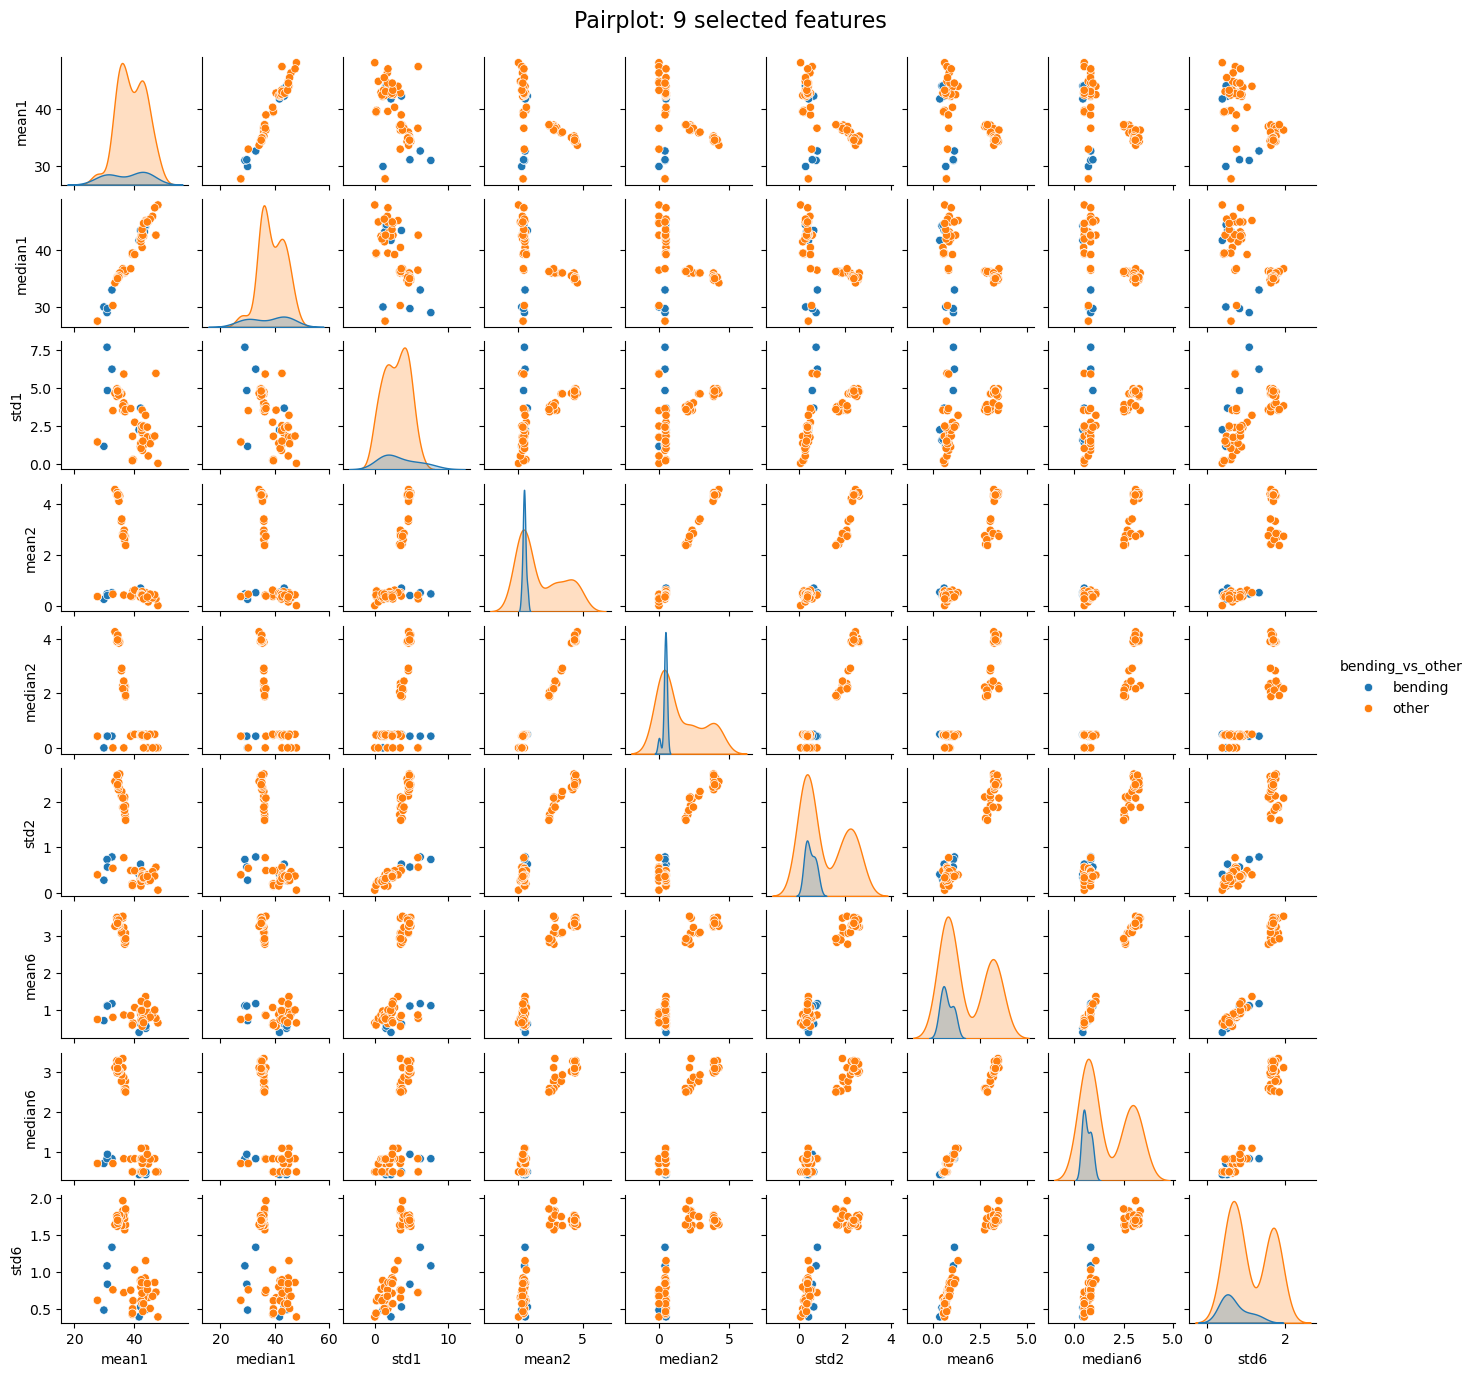

In [8]:
#Generating pairplot of 9 x 9 variables


selected_features = ["mean1", "median1", "std1", "mean2", "median2","std2", "mean6", "median6", "std6"]
sns.pairplot(train_result, vars = selected_features, hue = "bending_vs_other", height = 1.5) 
plt.suptitle("Pairplot: 9 selected features", y = 1.02, fontsize = 16)
plt.show()


 2)A)II) PAIRPLOTS AFTER SPLITTING DATA 
 -----------

In [9]:
pd.set_option("display.width", 300)
pd.set_option("display.max_columns", 10)
pd.set_option("display.float_format", "{:.2f}".format)  # Limit decimal places

result_split = []
index = 1

for df in train_dfs:
    row = [index]
    mid = len(df) // 2

    #Extracting features from 1st half of each training instance
    row.append(np.mean(df["avg_rss12"][:mid]))
    row.append(np.median(df["avg_rss12"][:mid]))
    row.append(np.std(df["avg_rss12"][:mid]))

    row.append(np.mean(df["var_rss12"][:mid]))
    row.append(np.median(df["var_rss12"][:mid]))
    row.append(np.std(df["var_rss12"][:mid]))

    row.append(np.mean(df["var_rss23"][:mid]))
    row.append(np.median(df["var_rss23"][:mid]))
    row.append(np.std(df["var_rss23"][:mid]))

    #Extracting features from 2nd half of each training instance
    row.append(np.mean(df["avg_rss12"][mid:]))
    row.append(np.median(df["avg_rss12"][mid:]))
    row.append(np.std(df["avg_rss12"][mid:]))

    row.append(np.mean(df["var_rss12"][mid:]))
    row.append(np.median(df["var_rss12"][mid:]))
    row.append(np.std(df["var_rss12"][mid:]))

    row.append(np.mean(df["var_rss23"][mid:]))
    row.append(np.median(df["var_rss23"][mid:]))
    row.append(np.std(df["var_rss23"][mid:]))

    row.append(df["activity"].iloc[0])

    result_split.append(row)
    index+=1 

result_columns = [
    "instance", "mean1_half1", "median1_half1", "std1_half1", "mean2_half1", "median2_half1", "std2_half1", 
    "mean6_half1", "median6_half1", "std6_half1", "mean1_half2", "median1_half2", "std1_half2", 
    "mean2_half2", "median2_half2", "std2_half2", "mean6_half2", "median6_half2", "std6_half2", "activity"
]

train_result_split = pd.DataFrame(result_split, columns = result_columns)

train_result_split["bending_vs_other"] = "other"
train_result_split.loc[train_result["activity"].isin(["bending1", "bending2"]), "bending_vs_other"] = "bending"

print(train_result_split)


    instance  mean1_half1  median1_half1  std1_half1  mean2_half1  ...  mean6_half2  median6_half2  std6_half2  activity  bending_vs_other
0          1        44.06          44.50        1.55         0.38  ...         0.39           0.00        0.48  bending1           bending
1          2        43.28          45.00        3.47         0.67  ...         0.59           0.47        0.49  bending1           bending
2          3        41.62          42.33        3.11         0.62  ...         0.35           0.43        0.36  bending1           bending
3          4        44.12          45.00        1.36         0.25  ...         0.54           0.50        0.47  bending1           bending
4          5        43.49          43.71        1.28         0.38  ...         0.59           0.50        0.49  bending1           bending
..       ...          ...            ...         ...          ...  ...          ...            ...         ...       ...               ...
64        65        33.33  

Splitting the 18x18 pairplot to 2 9x9 pairplots for better readability (it will be difficult to fit 18x18 in one image)

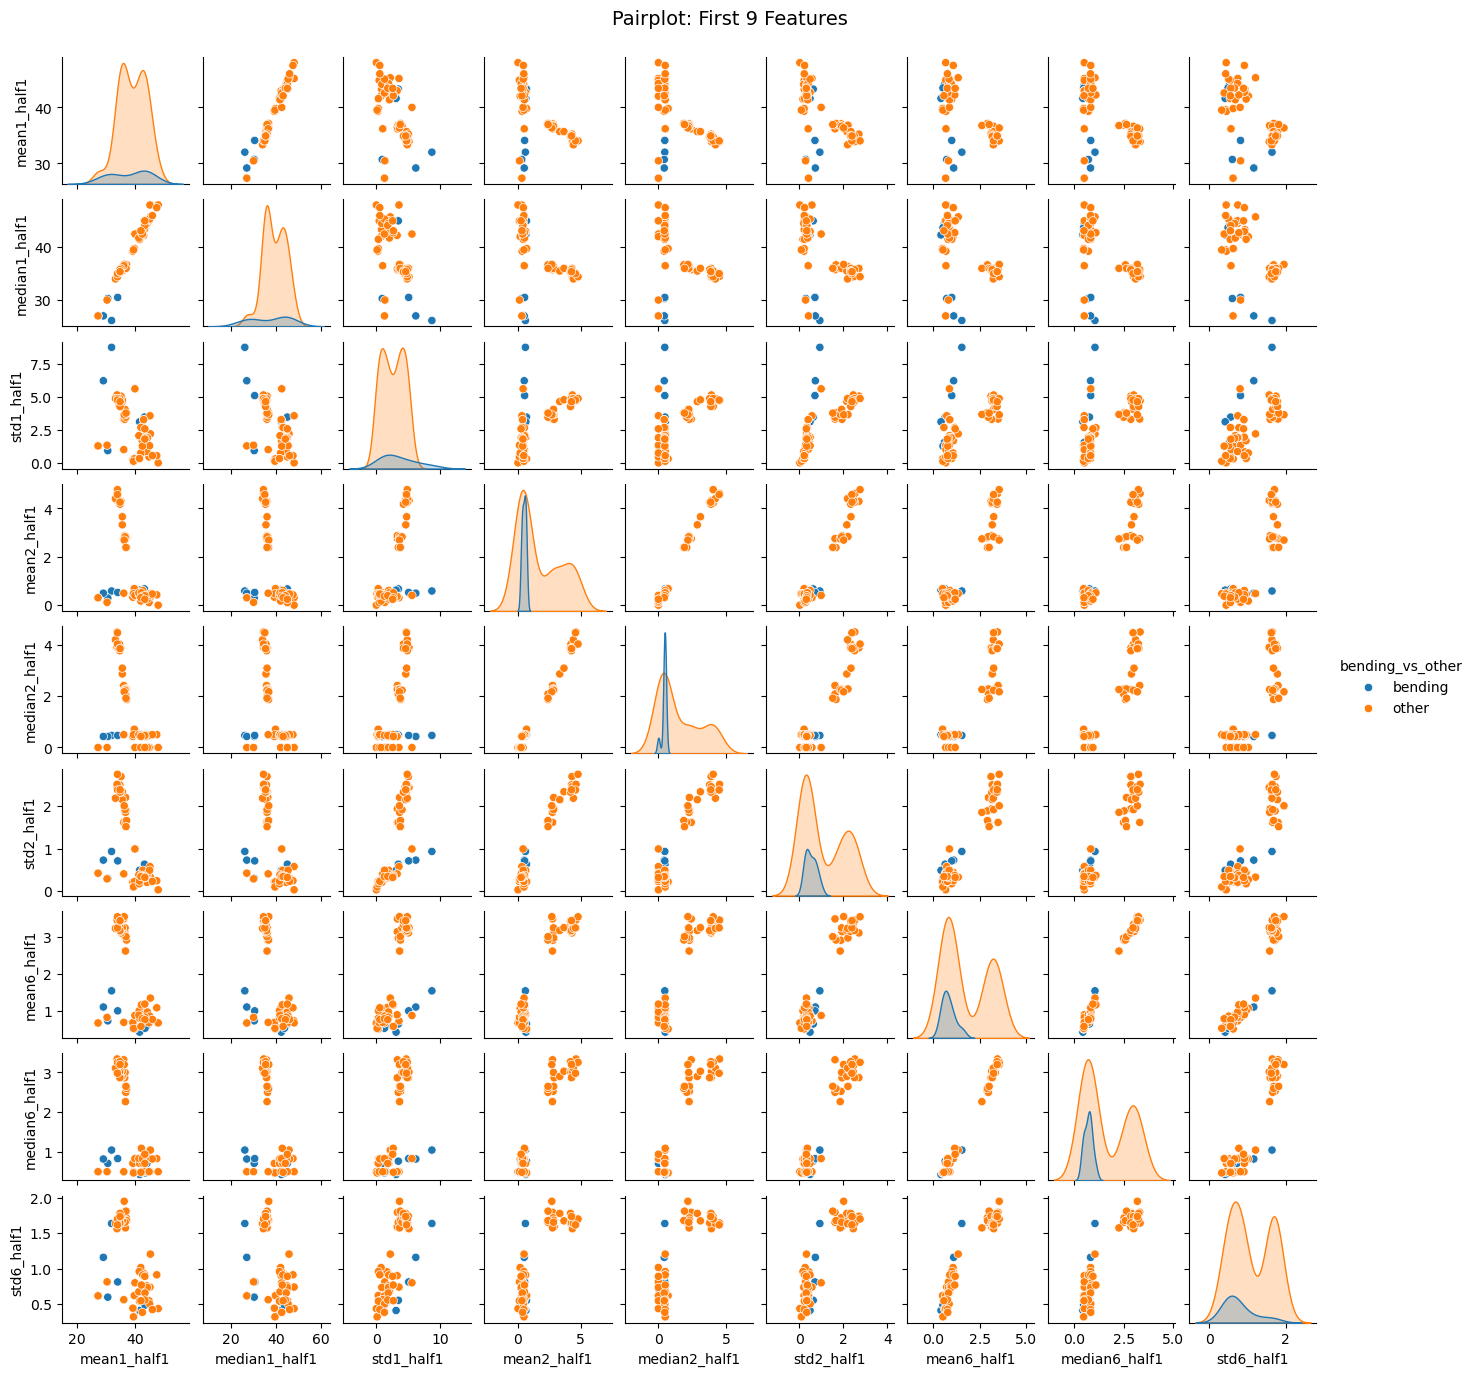

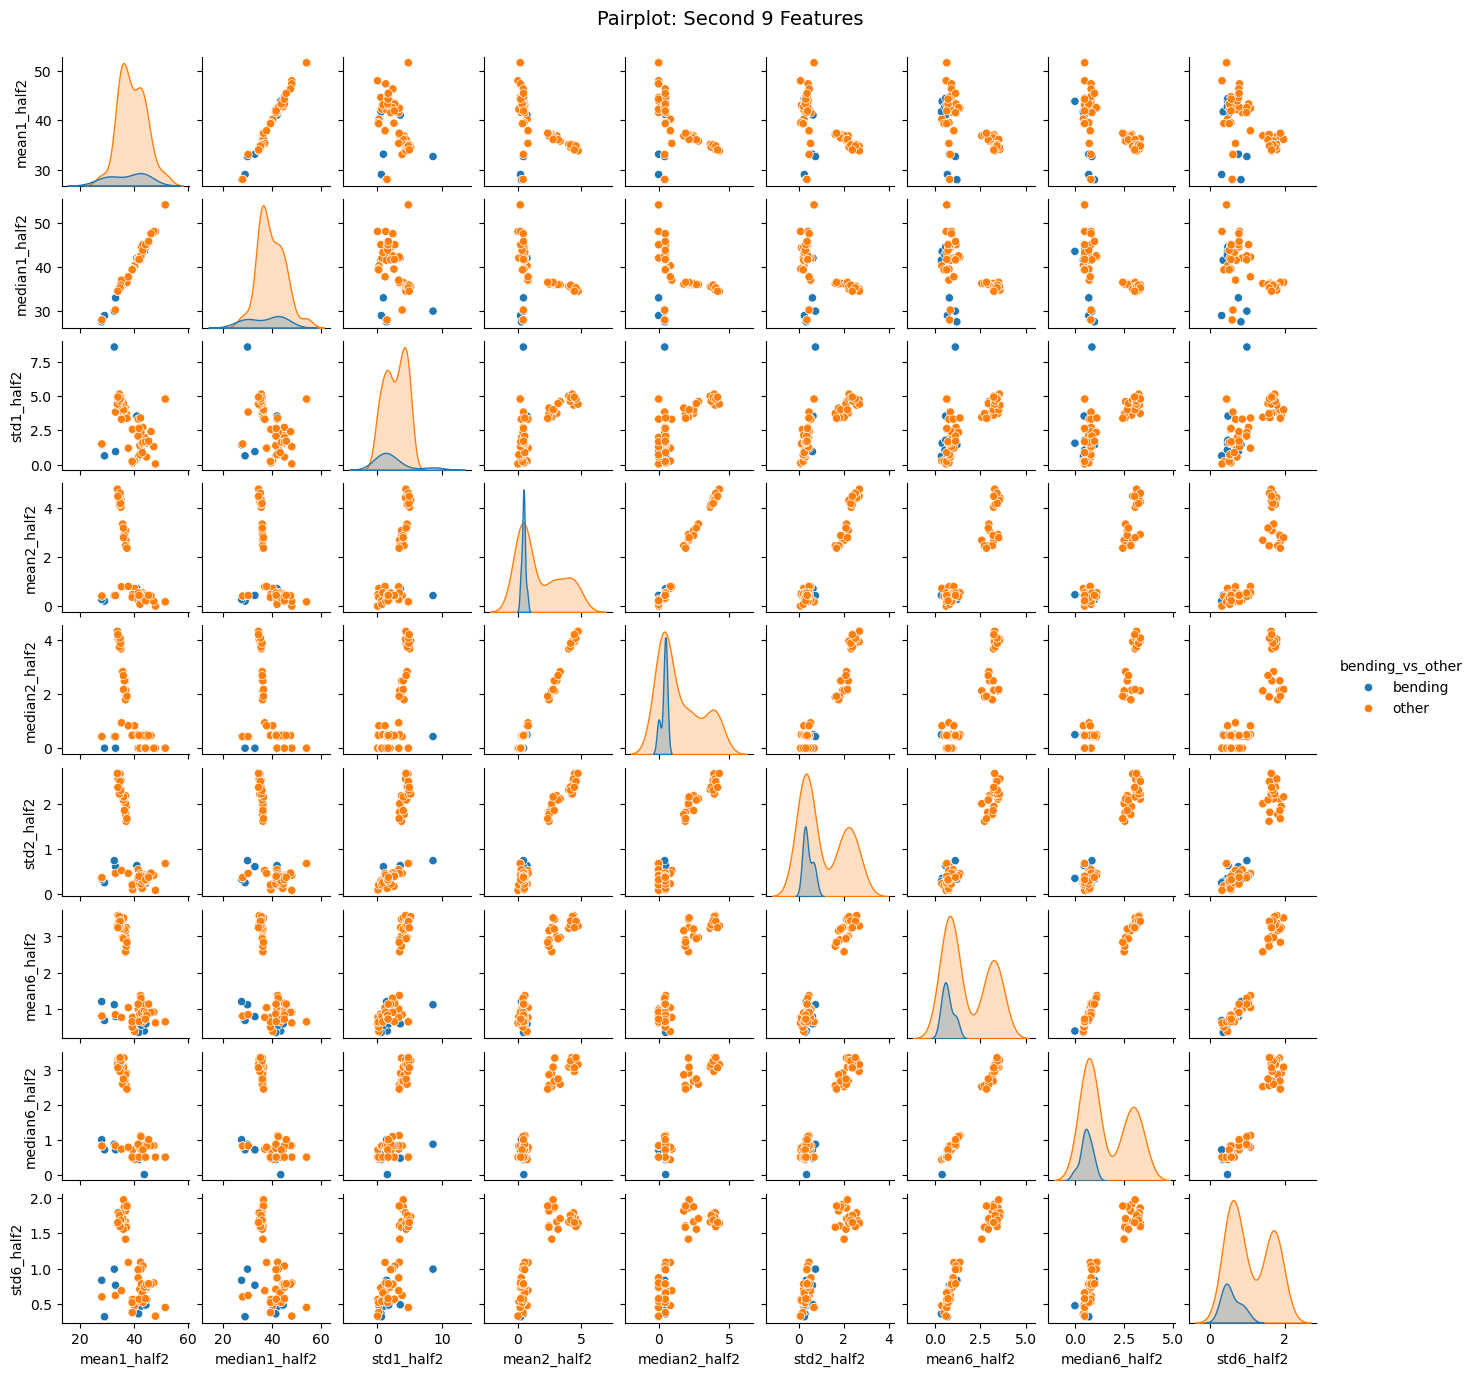

In [10]:

selected_features1 = [
    "mean1_half1", "median1_half1", "std1_half1", "mean2_half1", "median2_half1", "std2_half1",
    "mean6_half1", "median6_half1", "std6_half1"
]

selected_features2 = [
    "mean1_half2", "median1_half2", "std1_half2", "mean2_half2", "median2_half2", "std2_half2",
    "mean6_half2", "median6_half2", "std6_half2"
]

#
g1 = sns.pairplot(train_result_split, vars = selected_features1, hue = "bending_vs_other", height = 1.5)
plt.suptitle("Pairplot: First 9 Features", y= 1.02, fontsize = 14) 
plt.show()

g2 = sns.pairplot(train_result_split, vars = selected_features2, hue = "bending_vs_other", height = 1.5)
plt.suptitle("Pairplot: Second 9 Features", y= 1.02, fontsize = 14)
plt.show()


On initial observation, there weren’t many overall differences between the plots generated in 2a and 2b, there were some differences were more pronounced for bending features datapoints. For example:
1. bending pairplot plots for mean1 and std1 look different for the split vs. non-split dfs 
2. for median6 vs. std6, plots are different for 2a) and 2b) for bending points


--------------------------------------------------------------------------------------------------------------------------------------------
2)A)III)
-------------------------------------------------------------------------------------------------------------------------------------------
Cross Validation and Feature selection right Way and Wrong way : Source (ESL Textbook 7.10.2)

Wrong way: Performing Feature Selection before Cross-validation. i.e., Feature selection applied to entire dataset before splitting into train-test folds.

This is wrong because data leakage occurs, i.e. test set indirectly influences selected features and model is trained and tested on already optimized feature set leading to overly optimistic results

Right way: Perform feature selection within each training fold ensuring test data remains unseen. This avoids information leakage by selecting features inside each fold. 


Overall breakdown of steps for 2)a)iii

1. Extract Features from Time Series Data

   a) We split dataset into l equal segments (l = 1 to 20).

   b) Compute 7 domain features: Min, Max, Mean, Median, Std, 25th Percentile, 75th Percentile.

   c) Store extracted features in a matrix X with labels in y. Labels are assigned as 1 for bending and 0 for other activities. Also assign feature names as avg_var12_mean_seg0 etc. where avg_var12 represents time series, mean represents time domain feature and seg0 represents segment number from 0 to 19. 


2. Stratified k-fold Cross Validation

    a) Use 5 fold cross validation. Functions used: StratifiedKFold.n_splits = 5: use 5 folds. Prevents class imbalance. 


3. Logistic Regression and Recursive Feature Selection (RFECV)

    a) Function LogisticRegression() used with max_iter = 100, C=1e6 to remove effect of L2 regularization. Stored in model. 

    b) Within each fold, RFECV selects most important features. The average across folds is stored in rfecv.cv_results_['mean_test_score'].        Note that each value in rfecv.cv_results_['mean_test_score'] represents 1 subset size and the mean score corresponding to that              subset size across 5 folds

    c) We choose the max of these test scores to select optimal feature size. rfecv.n_features_ returns the number of features corresponding to the max test score.


4. Finding best l with p 

    a) Store test accuracy, number of selected features, and test error (1-accuracy) for each l.

    b) Out of all the l used above, track best segmentation (best_l) and feature count p.






Function to extract features (used again in later questions) 
---

In [11]:
def extract_features(train_dfs, l):
    """
    Extract time-series features for a value l.  
    Returns:
    feature_matrix: A NumPy array where each row is a feature vector for one dataset. 
    labels: NumPy array where each entry is class label (1 for bending, 0 for others)
    Feature names: list of feature names (column headers) 
    """
    feature_matrix = [] #stores feature data for all dataframes. initially empty. 
    labels = []
    feature_names = [] #stores feature names 
        
    for df in train_dfs: #Loop through every training dataframe
        labels.append(1 if df["activity"].iloc[0] in ["bending1", "bending2"] else 0) #assign labels as 1 for bending and 0 for all others

        #Generate l+1 evenly spaced indices for each dataframe which will be boundaries for each segment. This will depend on l value.
        #Thus, the indices would be the split points for each dataframe. 
        indices = np.linspace(0, len(df), l+1, dtype = int)

        features = [] #to store computed features for current dataset. Reset to empty for each df. 

        for i in range(l): #loops over l segments and extracts subset of rows (segments)
            segment = df.iloc[indices[i]: indices[i+1]]

            for col in df.columns: 
                if col not in ["activity", "time"]: #Exclude activity and time columns
                    # Define feature names for every segment
                    feature_names.append(f"{col}_min_seg{i}")
                    feature_names.append(f"{col}_max_seg{i}")
                    feature_names.append(f"{col}_mean_seg{i}")
                    feature_names.append(f"{col}_median_seg{i}")
                    feature_names.append(f"{col}_std_seg{i}")
                    feature_names.append(f"{col}_p25_seg{i}")
                    feature_names.append(f"{col}_p75_seg{i}")
                    features.extend([
                        np.min(segment[col]), np.max(segment[col]), np.mean(segment[col]),
                        np.median(segment[col]), np.std(segment[col]),
                        np.percentile(segment[col], 25), np.percentile(segment[col], 75)
                    ])
        #each datafram produces one row (features) which contains all computed features across all segments. 
        #This row is appended to feature_matrix as a single instance. Thus each dataframe represent a single row or instance.
        #Final shape of feature_matrix is (number of dataframes: 69 in training, number of features: depends on l) 
        feature_matrix.append(features)   
       
    #returning np.arrays for efficiency  and because LogisticRegression and RFECV expect NumPy arrays. 
    return np.array(feature_matrix), np.array(labels), feature_names


Function to train Logistic Regression using Cross Validation and Feature Selection.
--

Note: we used RFECV for feature selection and not P-values for feature extraction
--

In [12]:
pd.set_option("display.float_format", "{:.5f}".format)  # Limit decimal places
def train_logistic_reg(X, y, feature_names, cv_splits = 5):
    """
    Trains Logistic Regression with RFECV for feature selection. 
    Returns trained model, feature selector, and test accuracy. 
    """
    #Using StratifiedKFold for imbalanced dataset. Shuffle = false to ensure time order preserved. 
    cv = StratifiedKFold(n_splits = cv_splits, shuffle = True, random_state = 41) 

    selected_features = [] #Stores number of features selected in each fold
    fold_scores = [] #Stores test accuracy for each fold 
     
    model = LogisticRegression(C=1e6, max_iter = 100, solver = "lbfgs") 
    #max_iter = 1000 -> ensures enough iterations for convergence
    #solver = lbfgs (optimizer for small to medium datasets) 
    

    rfecv = RFECV(estimator= model, cv=cv, scoring="accuracy")
    #RFECV automatically selects best features using cross-validation within each fold
    #scoring = 'accuracy': feature importance based on classification accuracy

    rfecv.fit(X, y)

    
    # Get optimal number of features
    optimal_num_features = rfecv.n_features_

    # Get optimal feature names using selected feature indices
    optimal_indices = np.where(rfecv.support_)[0]
    optimal_features = [feature_names[i] for i in optimal_indices]
    
    # Get the best accuracy score from CV
    test_score = rfecv.cv_results_['mean_test_score'].max()



    return model, optimal_features, test_score, optimal_num_features
        
        

        

In [13]:
pd.set_option("display.float_format", "{:.5f}".format)  # Limit decimal places
l_values = list(range(1,21))

best_score = -np.inf
best_l = None
best_num_features = None

#Prepare dataset with different 'l' values. Each row will have value of l, test accuracy, number of selected features, and test error. 
results = []

#Train model for each 'l'
for l in l_values:
    X, y, feature_names = extract_features(train_dfs, l) #Splits dataset into l segments and computes 7 time domain features per segment. 
    model, selected_features, avg_score, avg_num_features = train_logistic_reg(X, y, feature_names)
    results.append((l, avg_score, avg_num_features, 1 - avg_score, selected_features))
    print(f"Code completed execution for l={l}")
    if avg_score > best_score:
        best_score = avg_score
        best_l = l
        best_num_features = avg_num_features
        best_features = selected_features
        
# Print best results
print(f"Best l: {best_l}, Best number of selected features (p): {best_num_features}")
print(f"Best features: {best_features}")
print(f"Best cross-validation accuracy: {best_score:.4f}, Best test error: {1 - best_score:.4f}")

# Print summary table
summary_df = pd.DataFrame(results, columns=["l", "Train Accuracy", "Num Features", "Train Error", "Selected Features"])
print(summary_df)


Code completed execution for l=1
Code completed execution for l=2
Code completed execution for l=3
Code completed execution for l=4
Code completed execution for l=5
Code completed execution for l=6
Code completed execution for l=7
Code completed execution for l=8
Code completed execution for l=9
Code completed execution for l=10
Code completed execution for l=11
Code completed execution for l=12
Code completed execution for l=13
Code completed execution for l=14
Code completed execution for l=15
Code completed execution for l=16
Code completed execution for l=17
Code completed execution for l=18
Code completed execution for l=19
Code completed execution for l=20
Best l: 13, Best number of selected features (p): 15
Best features: ['avg_rss23_min_seg1', 'avg_rss23_mean_seg1', 'avg_rss23_median_seg1', 'avg_rss23_p25_seg1', 'avg_rss23_p75_seg1', 'avg_rss23_max_seg2', 'avg_rss23_min_seg3', 'avg_rss23_p25_seg3', 'avg_rss12_max_seg6', 'avg_rss12_max_seg7', 'avg_rss12_p75_seg7', 'avg_rss12_max


Best train accuracy = 1.0. Best l and p combination: l: 13, Best number of selected features (p): 15
--



2A)IV) Confusion Matrix, ROC, AUC, p-Values
-----------------------------------

Training Data
---

In [14]:


# Train model on best l
X_optimal_train, y_optimal_train, all_feature_names = extract_features(train_dfs, best_l)
selected_indices = [all_feature_names.index(f) for f in best_features]  # Get indices of selected features
X_optimal_train = X_optimal_train[:, selected_indices]  # Keep only selected features

# Logistic Regression Coefficients and P-values for Best l
X_optimal_train_const = sm.add_constant(X_optimal_train)  # Add intercept
logit_model = sm.Logit(y_optimal_train, X_optimal_train_const)
summary = logit_model.fit(method='bfgs').summary()
print(summary)




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 23
         Function evaluations: 27
         Gradient evaluations: 27
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       53
Method:                           MLE   Df Model:                           15
Date:                Fri, 07 Mar 2025   Pseudo R-squ.:                   1.000
Time:                        16:03:08   Log-Likelihood:            -1.2872e-05
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 3.263e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0621   1.81e+05  -3.4

NOTE TO TAs:  DUE TO SYSTEM THAT I AM RUNNING THIS ON, P-VALUES ARE NOT COMPUTER CORRECTLY. I HAVE ALSO DISCUSSED THIS IN TA OFFICE HOURS WITH DAKSH. 

Function to evaluate model performance on train set. Called again later in 2B. 
-

RESULTS FOR TRAIN DATA
Train accuracy:  1.0
Confusion Matrix:
[[60  0]
 [ 0  9]]


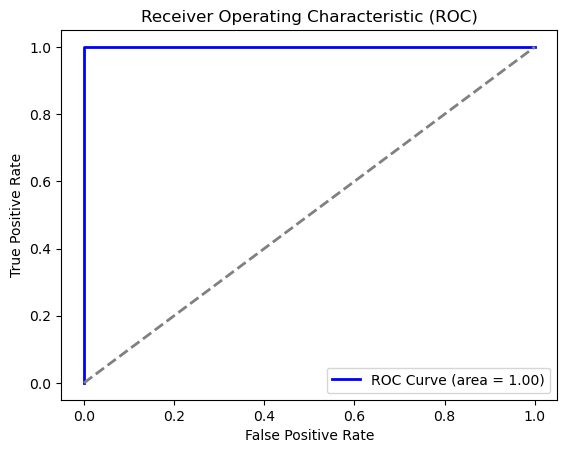

In [15]:
def train_model_eval(final_model, X_optimal_train, y_optimal_train): 
    """
    Calculates model accuracy, confusion matrix, ROC curve and AUC on training data.  
    Defining as a function here so it can be re-used later. 

    """
    #Calculating Train accuracy
    final_model.fit(X_optimal_train, y_optimal_train)
    y_optimal_pred = final_model.predict(X_optimal_train)
    train_score = final_model.score(X_optimal_train, y_optimal_train)
    print("RESULTS FOR TRAIN DATA")
    print ("Train accuracy: ", train_score)
    
    # Confusion Matrix
    c_matrix = confusion_matrix(y_optimal_train, y_optimal_pred)
    print("Confusion Matrix:")
    print(c_matrix)

    # ROC Curve and AUC
    y_prob = final_model.predict_proba(X_optimal_train)[:, 1]
    fpr, tpr, _ = roc_curve(y_optimal_train, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

train_model_eval(model, X_optimal_train, y_optimal_train) 


2)a) V) Testing the classifier on test set. 
----


Function to evaluate model performance on test set. Called again later in 2B.
-

RESULTS FOR TEST DATA: 
Test accuracy:  1.0
Confusion Matrix:
[[15  0]
 [ 0  4]]


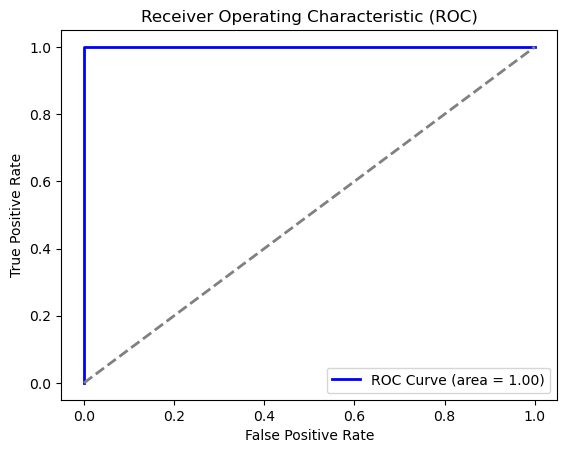

In [16]:
def test_model_eval(final_model, X_optimal_test, y_optimal_test): 
    """
    Calculates model accuracy, confusion matrix, ROC curve and AUC on test data.  
    Defining as a function here so it can be re-used later. 

    """
    #Calculating Test accuracy
    print("RESULTS FOR TEST DATA: ")
    y_optimal_pred = final_model.predict(X_optimal_test)
    test_score = final_model.score(X_optimal_test, y_optimal_test)
    print ("Test accuracy: ", test_score)
    
    
    # Confusion Matrix
    c_matrix = confusion_matrix(y_optimal_test, y_optimal_pred)
    print("Confusion Matrix:")
    print(c_matrix)

    # ROC Curve and AUC
    y_prob = final_model.predict_proba(X_optimal_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_optimal_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

#First we extract test set features using the best l
X_optimal_test, y_optimal_test, all_feature_names = extract_features(test_dfs, best_l)
selected_indices = [all_feature_names.index(f) for f in best_features]  # Get indices of selected features
X_optimal_test = X_optimal_test[:, selected_indices]  # Keep only selected features

test_model_eval(model, X_optimal_test, y_optimal_test) 





2)a)v) Findings: Accuracy score for train and test set is same: 1.0
----

2)a)vi) Complete Separation: The results show that there is complete separation or perfect prediction. 
--

2)A)vii) Yes the data has imbalance in it. Class 0 has 60 whereas class 1 is only 9 based on the training confusion matrix. 
This can bias the model towards predicting non-bending cases. 
--

Upsampling
--

In [17]:

def case_control_sampling(X, y):
    """
    Implements case-control sampling by selecting an equal number of cases (bending) and controls (other activities).
    If fewer than `target_samples` exist in a class, it defaults to the minimum available class size.
    """
    df = pd.DataFrame(X)
    df['label'] = y

    majority_class = df[df['label'] == 0]
    minority_class = df[df['label'] == 1]

    # Sample equal number of cases and controls
    majority_sampled = resample(df[df['label'] == 0], replace=True, n_samples=len(majority_class), random_state=41)
    minority_sampled = resample(df[df['label'] == 1], replace=True, n_samples=len(majority_class), random_state=41)
    
    balanced_df = pd.concat([majority_sampled, minority_sampled])
    
    X_balanced = balanced_df.drop(columns=['label']).to_numpy()
    y_balanced = balanced_df['label'].to_numpy()
    
    return X_balanced, y_balanced

# Re-run feature extraction and model training after balancing the dataset
l_values = list(range(1, 21))

best_score = -np.inf
best_l = None
best_num_features = None

# Prepare dataset with different 'l' values
results = []

for l in l_values:
    X, y, all_feature_names = extract_features(train_dfs, l)
    X_balanced, y_balanced = case_control_sampling(X, y)
    balanced_model, selected_features, avg_score, avg_num_features = train_logistic_reg(X_balanced, y_balanced, all_feature_names)
    results.append((l, avg_score, avg_num_features, 1 - avg_score, selected_features))
    print("Execution completed for l: ", l)
    
    if avg_score > best_score:
        best_score = avg_score
        best_l = l
        best_num_features = avg_num_features
        best_features = selected_features

# Print best results
print(f"Best l: {best_l}, Best number of selected features (p): {best_num_features}")
print(f"Best features: {best_features}")
print(f"Best cross-validation accuracy: {best_score:.4f}, Best train error: {1 - best_score:.4f}")

# Print summary table
summary_df = pd.DataFrame(results, columns=["l", "Train Accuracy", "Num Features", "Train Error", "Selected Features"])
print(summary_df)



Execution completed for l:  1
Execution completed for l:  2
Execution completed for l:  3
Execution completed for l:  4
Execution completed for l:  5
Execution completed for l:  6
Execution completed for l:  7
Execution completed for l:  8
Execution completed for l:  9
Execution completed for l:  10
Execution completed for l:  11
Execution completed for l:  12
Execution completed for l:  13
Execution completed for l:  14
Execution completed for l:  15
Execution completed for l:  16
Execution completed for l:  17
Execution completed for l:  18
Execution completed for l:  19
Execution completed for l:  20
Best l: 1, Best number of selected features (p): 4
Best features: ['avg_rss12_p75_seg0', 'avg_rss23_min_seg0', 'avg_rss23_max_seg0', 'avg_rss23_p25_seg0']
Best cross-validation accuracy: 1.0000, Best train error: 0.0000
     l  Train Accuracy  Num Features  Train Error                                  Selected Features
0    1         1.00000             4      0.00000  [avg_rss12_p75_se

RESULTS FOR TRAIN DATA
Train accuracy:  1.0
Confusion Matrix:
[[60  0]
 [ 0 60]]


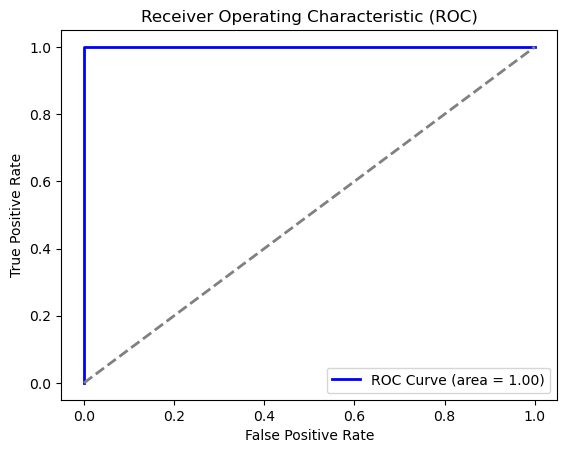

In [18]:
# Repeat model score, confusion matrix, ROC, AUC for training  set for the new model with case control sampling. 
# Train model on best l
X_raw_train, y_raw_train, all_feature_names = extract_features(train_dfs, best_l)
X_optimal_train, y_optimal_train = case_control_sampling(X_raw_train, y_raw_train)
selected_indices = [all_feature_names.index(f) for f in best_features]  # Get indices of selected features
X_optimal_train = X_optimal_train[:, selected_indices]  # Keep only selected features
train_model_eval(balanced_model, X_optimal_train, y_optimal_train) 

RESULTS FOR TEST DATA: 
Test accuracy:  1.0
Confusion Matrix:
[[15  0]
 [ 0  4]]


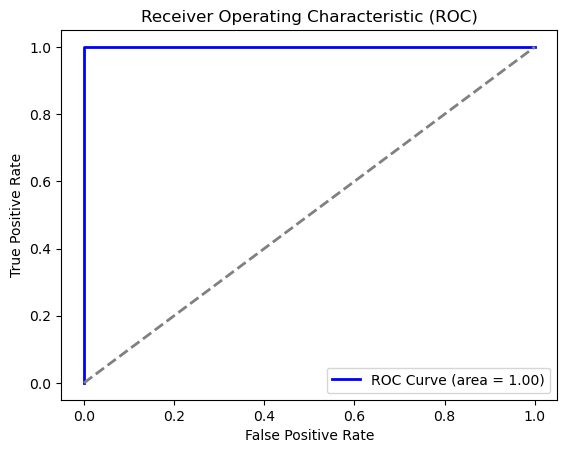

In [19]:
# Repeat model score confusion matrix, ROC, AUC for test set for the new model with case control sampling. 
X_optimal_test, y_optimal_test, all_feature_names = extract_features(test_dfs, best_l)
selected_indices = [all_feature_names.index(f) for f in best_features]  # Get indices of selected features
X_optimal_test = X_optimal_test[:, selected_indices]  # Keep only selected features
test_model_eval(balanced_model, X_optimal_test, y_optimal_test) 


2)A)VII) After adjusting for sample imbalance, train and test accuracy scores are still 1.0. Best l = 1, p = 4
-

2B)I) BINARY CLASSIFICATION USING L1 REGULARIZATION 
--

In [20]:

def l1_logistic_reg(X, y, feature_names, cv_splits=5):
    """
    Trains L1-penalized Logistic Regression using L1 regularization for feature selection.
    Returns trained model, selected features, and test accuracy. 
    """
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=41)
    model = LogisticRegressionCV(penalty='l1', max_iter=1000, scoring='accuracy', cv=cv, random_state=41, solver='liblinear')
    model.fit(X, y)
    
    # L1 Regularization naturally performs feature selection by setting some coefficients to zero
    selected_features = [feature_names[i] for i in range(X.shape[1]) if model.coef_[0, i] != 0]
    train_score = model.score(X,y)
    

    return model, selected_features, train_score, len(selected_features)

In [21]:
results = []
best_score = -np.inf
best_l, best_num_features, best_features = None, None, None
scaler = StandardScaler()

for l in l_values:
    X, y, feature_names = extract_features(train_dfs, l) 
    X = scaler.fit_transform(X)  # Normalize features
    l1_model, selected_features, avg_score, avg_num_features = l1_logistic_reg(X, y, feature_names)
    results.append((l, avg_score, avg_num_features, 1 - avg_score, selected_features))
    print("Code execution completed for l: ", l)
    if avg_score > best_score:
        best_score = avg_score
        best_l = l
        best_num_features = avg_num_features
        best_features = selected_features
        
print(f"Best l: {best_l}, Best number of selected features (p): {best_num_features}")
print(f"Best features: {best_features}")
print(f"Best cross-validation accuracy: {best_score:.4f}, Best test error: {1 - best_score:.4f}")

summary_df = pd.DataFrame(results, columns=["l", "Train Accuracy", "Num Features", "Train Error", "Selected Features"])
print(summary_df)

Code execution completed for l:  1
Code execution completed for l:  2
Code execution completed for l:  3
Code execution completed for l:  4
Code execution completed for l:  5
Code execution completed for l:  6
Code execution completed for l:  7
Code execution completed for l:  8
Code execution completed for l:  9
Code execution completed for l:  10
Code execution completed for l:  11
Code execution completed for l:  12
Code execution completed for l:  13
Code execution completed for l:  14
Code execution completed for l:  15
Code execution completed for l:  16
Code execution completed for l:  17
Code execution completed for l:  18
Code execution completed for l:  19
Code execution completed for l:  20
Best l: 1, Best number of selected features (p): 8
Best features: ['avg_rss12_p75_seg0', 'var_rss12_max_seg0', 'avg_rss13_p25_seg0', 'var_rss13_p25_seg0', 'avg_rss23_min_seg0', 'avg_rss23_max_seg0', 'avg_rss23_p25_seg0', 'var_rss23_p25_seg0']
Best cross-validation accuracy: 1.0000, Best t

We can see that the best cross validation accuracy  is obtained when l = 1. 
Best l: 1, Best number of selected features (p): 14
Train Accuracy: 1.0
--

RESULTS FOR TRAIN DATA
Train accuracy:  0.9855072463768116
Confusion Matrix:
[[60  0]
 [ 1  8]]


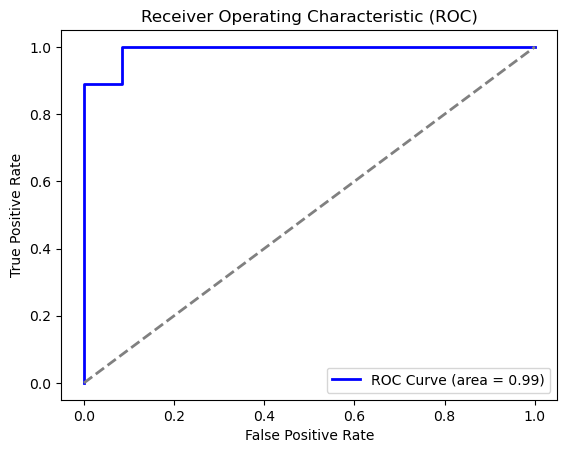

In [22]:

# Train model on best l
X_optimal_train, y_optimal_train, all_feature_names = extract_features(train_dfs, best_l)
X_optimal_train = scaler.fit_transform(X_optimal_train)  # Normalize train set
selected_indices = [all_feature_names.index(f) for f in best_features]  # Get indices of selected features
X_optimal_train = X_optimal_train[:, selected_indices]  # Keep only selected features
train_model_eval(l1_model, X_optimal_train, y_optimal_train) 



RESULTS FOR TEST DATA: 
Test accuracy:  0.9473684210526315
Confusion Matrix:
[[15  0]
 [ 1  3]]


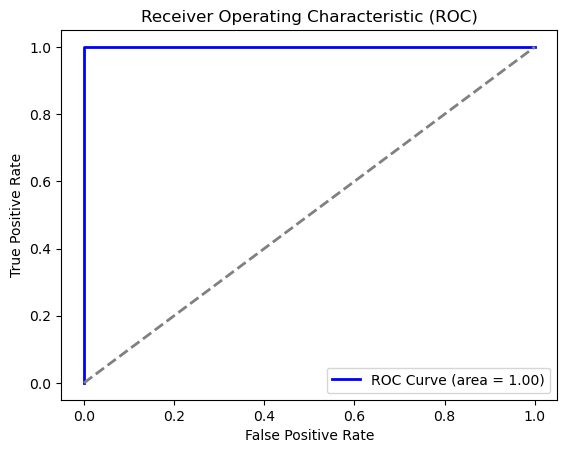

In [23]:


#First we extract test set features using the best l
X_optimal_test, y_optimal_test, all_feature_names = extract_features(test_dfs, best_l)
X_optimal_test = scaler.transform(X_optimal_test)  # Normalize test set
selected_indices = [all_feature_names.index(f) for f in best_features]  # Get indices of selected features
X_optimal_test = X_optimal_test[:, selected_indices]  # Keep only selected features

test_model_eval(l1_model, X_optimal_test, y_optimal_test) 


Test score has reduced to 0.95 for test data with L1 penalized.
-

2)b)ii)  
Model in 2A: Train and Test model scores: 1.0. 
L1 Penalized model: Train accuracy score: 1.0, Test accuracy score: 0.95
-

Logistic regression without the L1 penalized performs better wrt. test accuracy score. .
--

Note:
--
CANNOT COMPARE P VALUES. DUE TO SYSTEM THAT I AM RUNNING THIS ON, P-VALUES ARE NOT COMPUTER CORRECTLY (ALL DISPLAYED AS 1.0). I HAVE ALSO DISCUSSED THIS IN TA OFFICE HOURS

2C) MULTICLASS
--
2)C)I)
--


In [24]:
def extract_features_multiclass(dataframes, l):
    """
    Extracts time-series features for multi-class classification.
    Combines 'bending1' and 'bending2' into a single 'bending' class. 
    Converts all labels to numeric values
    """
    feature_matrix = []
    labels = []
    feature_names = []
    
    # Define feature names once using the first dataframe
    first_df = dataframes[0]
    for col in first_df.columns:
        if col not in ["activity", "time"]:
            for i in range(l):
                feature_names.extend([
                    f"{col}_min_seg{i}", f"{col}_max_seg{i}", f"{col}_mean_seg{i}",
                    f"{col}_median_seg{i}", f"{col}_std_seg{i}", f"{col}_p25_seg{i}", f"{col}_p75_seg{i}"
                ])
    
    # Process each dataframe
    for df in dataframes:
        activity = df["activity"].iloc[0]
        label = "bending" if activity in ["bending1", "bending2"] else activity
        labels.append(label)
        
        indices = np.linspace(0, len(df), l+1, dtype=int)
        features = []
        
        for i in range(l):
            segment = df.iloc[indices[i]: indices[i+1]]
            for col in df.columns:
                if col not in ["activity", "time"]:
                    features.extend([
                        np.min(segment[col]), np.max(segment[col]), np.mean(segment[col]),
                        np.median(segment[col]), np.std(segment[col]),
                        np.percentile(segment[col], 25), np.percentile(segment[col], 75)
                    ])
        
        feature_matrix.append(features)
    
    return np.array(feature_matrix), np.array(labels), feature_names


In [25]:


def evaluate_multiclass(model, X, y, y_numeric,unique_labels):
    """
    Evaluates a trained multiclass model using Confusion Matrix and ROC curves.
    """
    
   
    # Compute accuracy
    score = model.score(X, y_numeric)
    print("Accuracy: ", score)
    
    # Compute Confusion Matrix
    y_pred = model.predict(X)
    
    cm = confusion_matrix(y_numeric, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
    
    # Compute ROC curve and ROC area for each class
    y_bin = label_binarize(y_numeric, classes=range(len(unique_labels)))
    y_score = model.predict_proba(X)
    
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(len(unique_labels)):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot all ROC curves
    plt.figure()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple'])
    for i, color in zip(range(len(unique_labels)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
   

In [26]:
def l1_multiclass_logistic_reg(X, y, feature_names, cv_splits=5):
    """
    Trains L1-penalized Logistic Regression using L1 regularization for feature selection.
    Returns trained model, selected features, and test accuracy. 
    """
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=41)
    model = LogisticRegressionCV(penalty='l1', max_iter=50000, tol=1e-4, scoring='accuracy', cv=cv, random_state=41, solver='saga')
    model.fit(X, y)
    
    selected_features = [feature_names[i] for i in range(X.shape[1]) if model.coef_[0, i] != 0]
    
    train_score = model.score(X, y)
    
    return model, selected_features, train_score, len(selected_features)

In [27]:

best_score = -np.inf
best_l, best_num_features, best_features = None, None, None
results = []

for l in l_values:
    X, y, feature_names = extract_features_multiclass(train_dfs, l) 

    # Convert class labels to numeric values for multiclass classification
    unique_labels = list(set(y))
    label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
    y_numeric = np.array([label_mapping[label] for label in y])
    
    X = scaler.fit_transform(X)
    l1_multiclass_model, selected_features, avg_score, avg_num_features = l1_multiclass_logistic_reg(X, y_numeric, feature_names)
    results.append((l, avg_score, avg_num_features, 1 - avg_score, selected_features))
    print("Code execution completed for l: ", l)

    #Find l with best score
    if avg_score > best_score:
        best_score = avg_score
        best_l = l
        best_num_features = avg_num_features
        best_features = selected_features

print(f"Best l: {best_l}, Best number of selected features (p): {best_num_features}")
print(f"Best features: {best_features}")
print(f"Best cross-validation accuracy: {best_score:.4f}, Best test error: {1 - best_score:.4f}")

summary_df = pd.DataFrame(results, columns=["l", "Train Accuracy", "Num Features", "Train Error", "Selected Features"])
print(summary_df)

Code execution completed for l:  1
Code execution completed for l:  2
Code execution completed for l:  3
Code execution completed for l:  4
Code execution completed for l:  5
Code execution completed for l:  6
Code execution completed for l:  7
Code execution completed for l:  8
Code execution completed for l:  9
Code execution completed for l:  10
Code execution completed for l:  11
Code execution completed for l:  12
Code execution completed for l:  13
Code execution completed for l:  14
Code execution completed for l:  15
Code execution completed for l:  16
Code execution completed for l:  17
Code execution completed for l:  18
Code execution completed for l:  19
Code execution completed for l:  20
Best l: 2, Best number of selected features (p): 27
Best features: ['avg_rss12_mean_seg0', 'avg_rss12_median_seg0', 'avg_rss12_p75_seg0', 'avg_rss12_max_seg1', 'var_rss12_mean_seg0', 'var_rss12_median_seg0', 'var_rss12_std_seg0', 'var_rss12_p25_seg0', 'var_rss12_p75_seg0', 'avg_rss13_min_

In [28]:
# Evaluate performance on training set

#First Extract Features for best l 
X_train, y_train, feature_train = extract_features_multiclass(train_dfs, best_l)
X_train = scaler.fit_transform(X_train)
unique_labels = list(set(y_train))
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
y_train_numeric = np.array([label_mapping[label] for label in y_train])

#Fit model on best l
l1_multiclass_model.fit(X_train, y_train_numeric)
train_score = l1_multiclass_model.score(X_train, y_train_numeric)
print ("Train accuracy:", train_score)

#Evaluate performance on test set 

#First extract features in test set
X_test, y_test, feature_test = extract_features_multiclass(test_dfs, best_l)
X_test = scaler.transform(X_test)
unique_labels = list(set(y_test))
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
y_test_numeric = np.array([label_mapping[label] for label in y_test])

test_score = l1_multiclass_model.score(X_test, y_test_numeric)
print ("Test accuracy: ", test_score)


Train accuracy: 1.0
Test accuracy:  0.8421052631578947


2C)i) With L1 penalized multiclass, best train accuracy = 1.0, best test accuracy = 0.84. best l = 1, p = 
--

ROC and Confusion Matrix for TRAINING DATA
Accuracy:  1.0


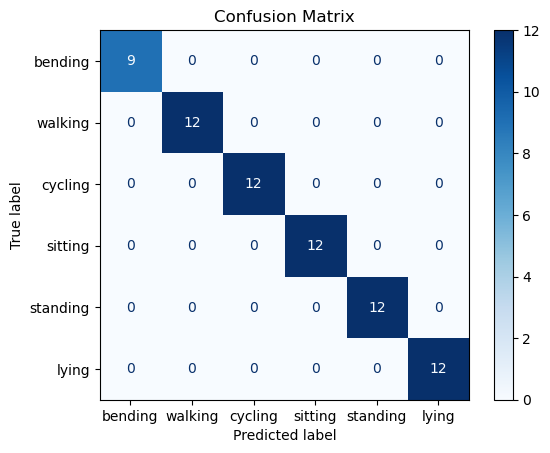

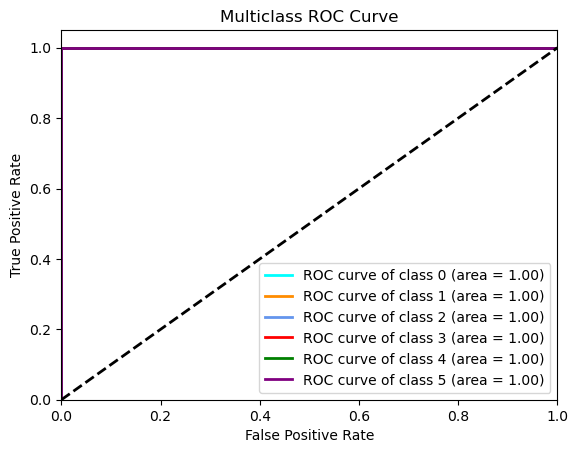

ROC and Confusion Matrix for TEST DATA
Accuracy:  0.8421052631578947


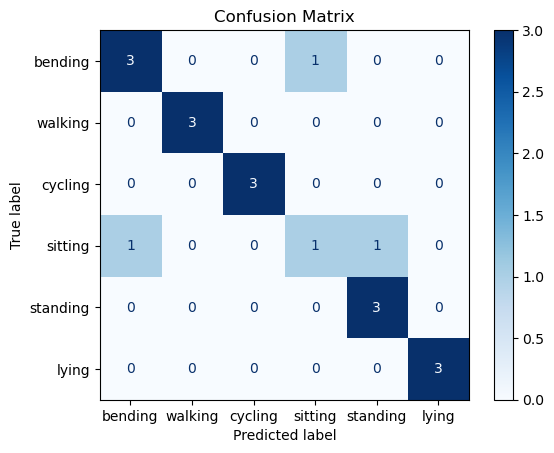

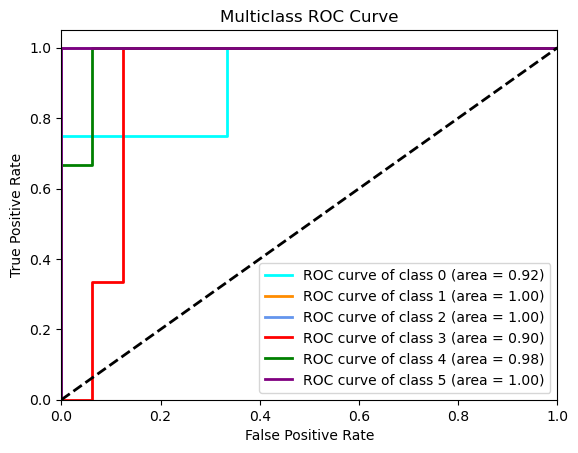

In [29]:
#Plot ROC curves and calculate Confusion Matrix for Train and Test for L1 penalized multiclass model: 
print("ROC and Confusion Matrix for TRAINING DATA")
evaluate_multiclass(l1_multiclass_model, X_train, y_train, y_train_numeric, unique_labels)
print("ROC and Confusion Matrix for TEST DATA")
evaluate_multiclass(l1_multiclass_model, X_test, y_test, y_test_numeric, unique_labels)

2)C)ii) Naive Bayes Model: 
--

Multinomial Priors: 
--

In [30]:

def multinomial_naive_bayes(X, y, cv_splits=5):
    """
    Builds Naive Bayes model using Multinomial priors
    """
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=41)
    model = MultinomialNB()
    model.fit(X, y)
    train_score = model.score(X, y)
    return model, train_score


In [31]:
results = []
best_score = -np.inf
best_l, best_num_features, best_features = None, None, None

for l in l_values:
    X, y, feature_names = extract_features_multiclass(train_dfs, l)
    # Convert labels to numeric values for multiclass classification
    unique_labels = list(set(y))
    label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
    y_numeric = np.array([label_mapping[label] for label in y])
    NB_model, avg_score = multinomial_naive_bayes(X, y_numeric)
    results.append((l, avg_score, len(feature_names), 1 - avg_score))
    print("Code execution completed for l: ", l)
    if avg_score > best_score:
        best_score = avg_score
        best_l = l
        best_num_features = len(feature_names)
print("Naive Bayes Classifier using Multinomial Distribution")       
print(f"Best l: {best_l}, Best number of selected features (p): {best_num_features}")

print(f"Best cross-validation accuracy: {best_score:.4f}, Best test error: {1 - best_score:.4f}")

summary_df = pd.DataFrame(results, columns=["l", "Train Accuracy", "Num Features", "Train Error"])
print(summary_df)

Code execution completed for l:  1
Code execution completed for l:  2
Code execution completed for l:  3
Code execution completed for l:  4
Code execution completed for l:  5
Code execution completed for l:  6
Code execution completed for l:  7
Code execution completed for l:  8
Code execution completed for l:  9
Code execution completed for l:  10
Code execution completed for l:  11
Code execution completed for l:  12
Code execution completed for l:  13
Code execution completed for l:  14
Code execution completed for l:  15
Code execution completed for l:  16
Code execution completed for l:  17
Code execution completed for l:  18
Code execution completed for l:  19
Code execution completed for l:  20
Naive Bayes Classifier using Multinomial Distribution
Best l: 6, Best number of selected features (p): 252
Best cross-validation accuracy: 0.9565, Best test error: 0.0435
     l  Train Accuracy  Num Features  Train Error
0    1         0.92754            42      0.07246
1    2         0.8

In [32]:
# Evaluate performance on training set
print("Performance of Naive Bayes model with Multinomial priors")
#First Extract Features for best l = 6
X_train, y_train, feature_train = extract_features_multiclass(train_dfs, best_l)
unique_labels = list(set(y_train))
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
y_train_numeric = np.array([label_mapping[label] for label in y_train])

#Fit model on best l
NB_model.fit(X_train, y_train_numeric)
train_score = NB_model.score(X_train, y_train_numeric)
print ("Train accuracy:", train_score)

#Evaluate performance on test set 

#First extract features in test set
X_test, y_test, feature_test = extract_features_multiclass(test_dfs, best_l)
unique_labels = list(set(y_test))
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
y_test_numeric = np.array([label_mapping[label] for label in y_test])

test_score = NB_model.score(X_test, y_test_numeric)
print ("Test accuracy: ", test_score)



Performance of Naive Bayes model with Multinomial priors
Train accuracy: 0.9565217391304348
Test accuracy:  0.8421052631578947


ROC and Confusion Matrix for TRAINING DATA for Naive Bayes Multinomial Priors
Accuracy:  0.9565217391304348


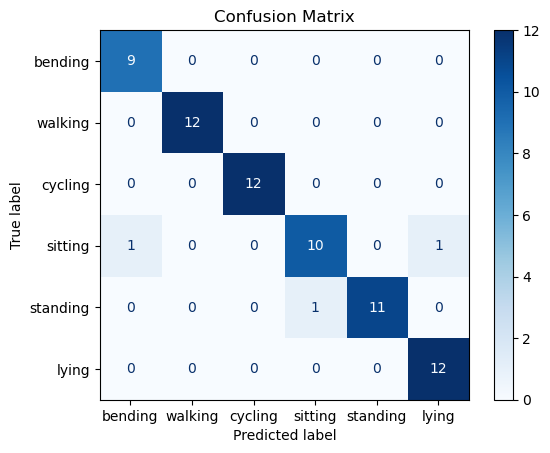

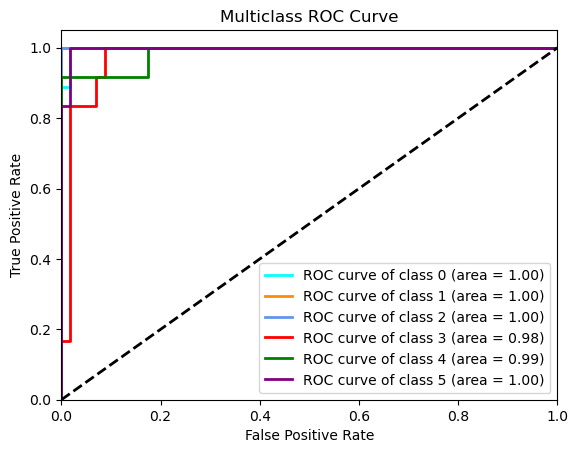

ROC and Confusion Matrix for TEST DATA Naive Bayes Multinomial Priors
Accuracy:  0.8421052631578947


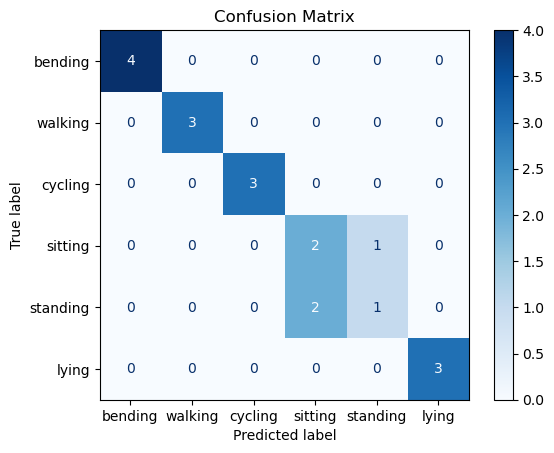

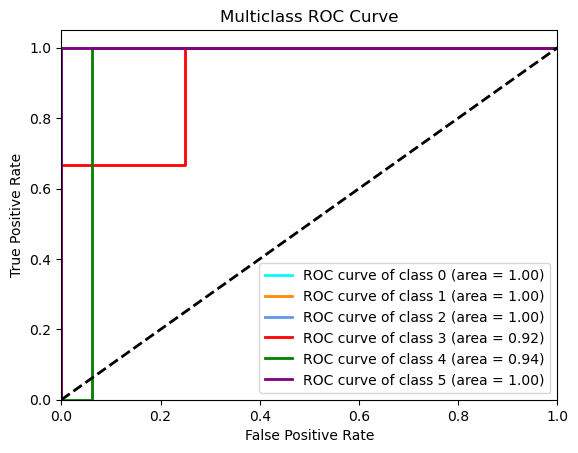

In [33]:
#Plot ROC curves and calculate Confusion Matrix for Train and Test for Naive Bayes Multinomial priors:
print("ROC and Confusion Matrix for TRAINING DATA for Naive Bayes Multinomial Priors")
evaluate_multiclass(NB_model, X_train, y_train, y_train_numeric, unique_labels)
print("ROC and Confusion Matrix for TEST DATA Naive Bayes Multinomial Priors")
evaluate_multiclass(NB_model, X_test, y_test,y_test_numeric, unique_labels)

Gaussian Priors: 
--

In [34]:
def gaussian_naive_bayes(X, y, cv_splits=5):
    """
    Builds Naive Bayes model using Gaussian
    """
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=41)
    model = GaussianNB()
    model.fit(X, y)
    train_score = model.score(X, y)
    return model, train_score


In [35]:
results = []
best_score = -np.inf
best_l, best_num_features, best_features = None, None, None

for l in l_values:
    X, y, feature_names = extract_features_multiclass(train_dfs, l)
    # Convert labels to numeric values for multiclass classification
    unique_labels = list(set(y))
    label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
    y_numeric = np.array([label_mapping[label] for label in y])
    gaussian_model, avg_score = gaussian_naive_bayes(X, y_numeric)
    results.append((l, avg_score, len(feature_names), 1 - avg_score))
    print("Code execution completed for l: ", l)
    if avg_score > best_score:
        best_score = avg_score
        best_l = l
        best_num_features = len(feature_names)
print("Naive Bayes Classifier using Gaussian Distribution")       
print(f"Best l: {best_l}, Best number of selected features (p): {best_num_features}")

print(f"Best cross-validation accuracy: {best_score:.4f}, Best test error: {1 - best_score:.4f}")

summary_df = pd.DataFrame(results, columns=["l", "Train Accuracy", "Num Features", "Train Error"])
print(summary_df)

Code execution completed for l:  1
Code execution completed for l:  2
Code execution completed for l:  3
Code execution completed for l:  4
Code execution completed for l:  5
Code execution completed for l:  6
Code execution completed for l:  7
Code execution completed for l:  8
Code execution completed for l:  9
Code execution completed for l:  10
Code execution completed for l:  11
Code execution completed for l:  12
Code execution completed for l:  13
Code execution completed for l:  14
Code execution completed for l:  15
Code execution completed for l:  16
Code execution completed for l:  17
Code execution completed for l:  18
Code execution completed for l:  19
Code execution completed for l:  20
Naive Bayes Classifier using Gaussian Distribution
Best l: 9, Best number of selected features (p): 378
Best cross-validation accuracy: 1.0000, Best test error: 0.0000
     l  Train Accuracy  Num Features  Train Error
0    1         0.98551            42      0.01449
1    2         0.9855

In [36]:
# Evaluate performance on training set

#First Extract Features for best l. 
X_train, y_train, feature_train = extract_features_multiclass(train_dfs, best_l)
unique_labels = list(set(y_train))
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
y_train_numeric = np.array([label_mapping[label] for label in y_train])

#Fit model on best l
gaussian_model.fit(X_train, y_train_numeric)
y_train_pred = gaussian_model.predict(X_train)
train_score = gaussian_model.score(X_train, y_train_numeric)
print ("Train accuracy:", train_score)

#Evaluate performance on test set 

#First extract features in test set
X_test, y_test, feature_test = extract_features_multiclass(test_dfs, best_l)
unique_labels = list(set(y_test))
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
y_test_numeric = np.array([label_mapping[label] for label in y_test])

test_score = gaussian_model.score(X_test, y_test_numeric)
print ("Test accuracy: ", test_score)



Train accuracy: 1.0
Test accuracy:  0.8421052631578947


ROC Curves and Confusion Matrix for Naive Bayes Gaussian Priors

Summary of Multiclass models: All multiclass models have the same test error
--

1. L1 Penalized multiclass Regression: Training Error: 1.0, Test error: 0.84
   -
3. Naive Bayes (Multinomial Priors): Training error: 0.96, 0.84
   --
5. Naive Bayes (Gaussian Priors): Training error: 1.0, Test error: 0.84
   --



ROC and Confusion Matrix for TRAINING DATA
Accuracy:  1.0


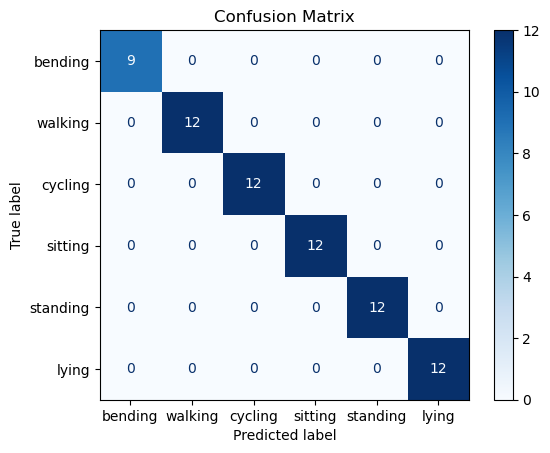

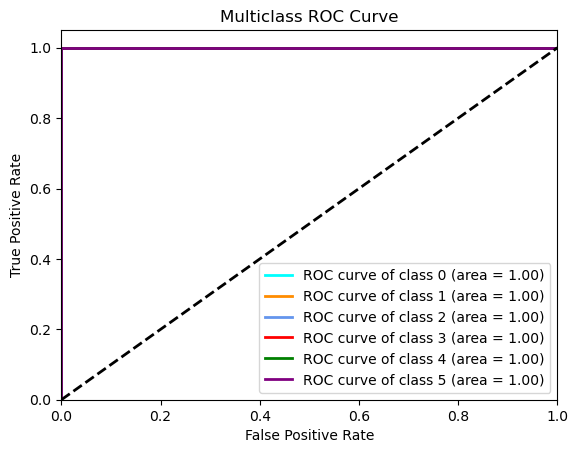

ROC and Confusion Matrix for TEST DATA
Accuracy:  0.8421052631578947


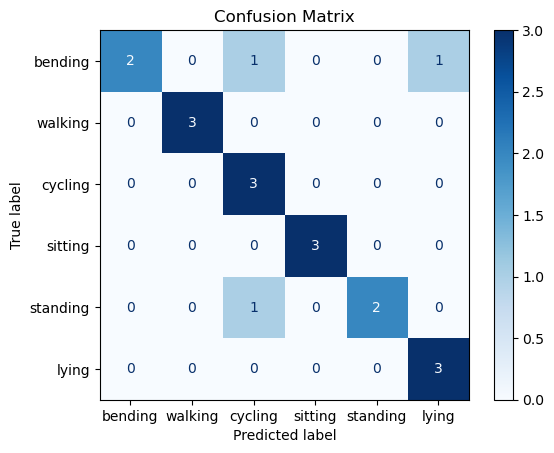

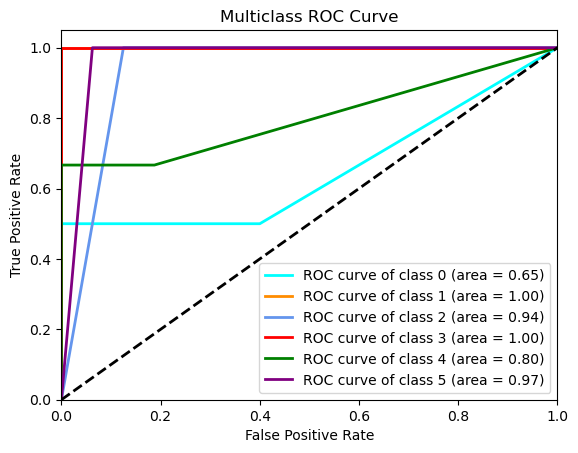

In [37]:
#Plot ROC curves and calculate Confusion Matrix for Train and Test for Naive Bayes Gaussian priors:
print("ROC and Confusion Matrix for TRAINING DATA")
evaluate_multiclass(gaussian_model, X_train, y_train, y_train_numeric, unique_labels)
print("ROC and Confusion Matrix for TEST DATA")
evaluate_multiclass(gaussian_model, X_test, y_test, y_test_numeric, unique_labels)

----------------------------------------------------------------------------------------------------------------------------------------
Sources

ESL 7.10.2

https://www.kaggle.com/code/magedmallek/feature-selection-explained-rfecv

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html

https://medium.com/@arnavr/scikit-learn-solvers-explained-780a17bc322d

https://www.geeksforgeeks.org/python-list-extend-method/

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.html

https://www.geeksforgeeks.org/recursive-feature-elimination-with-cross-validation-in-scikit-learn/

https://www.geeksforgeeks.org/comparing-various-online-solvers-in-scikit-learn/

https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html

https://www.kaggle.com/code/nadare/simple-logistic-regression-with-l1-penalty/notebook?scriptVersionId=10368578

https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html

Prompts for Google & ChatGPT:

1.	How to create a new column and have values from previous columns. E.g., new column would be bending if previous column was bending1 and bending , otherwise keep as other
  
2. How to limit number of columns shown in dataframe?

3.	In Seaborn pairplot: how to change height to enlarge views

4. In Seaborn pairplot, how to add titles? How to change position of title to avoid overlap with the data? 

5.	How to define list of indices to split a data frame. E.g., split dataframe into 20

6.	How to split a dataframe into segments and create new columns using those segments. How to use .extend() function

7.	How to return lists as np arrays (X, y) 

9.	How to use Stratified K Fold. What do the different arguments represent?

10.	How to set a high C for LogisticRegression

11.	What to use as max_iter for LogisticRegression. Which solver to use? 

12.	Is there a package that automatically does the feature selection within each cross validation fold? 

13.	How to use RFECV? What are the different parameters? 

14. How to plot ROC AUC curve.How to get confusion matrix from logistic regression model for binary classification

15. How to plot ROC and get confusion matrix for multiclass? 

16.	How to get the optimal number of features from RFECV? (n_features_) 

17.	How to get the score from RFECV? (cv_results_)

18.	How to get feature names from RFECV? 

19.	How to calculate model scores for logistic regression model?

20.	 How to change the floating point display of all numbers in the code? 

21.	How to get p values and parameter coefficients for logistic regression model ?

22.	How to up sample and down sample to balance classes? 

23.	How to use L1 regularization using LinearRegressionCV. How does package automatically calculate weights

24.	How to automatically do feature selection using L1 regularization? How to output test scores?

25.	How do I convert text classes to numeric classes? (using enumerate) 

26.	How to build Naïve Bayes model using multinomial priors? 

27.	How to change to Naïve Bayes using Gaussian priors





Q3 & Q4) Questions from the Textbook: 4.8.3 and 4.8.7

*********************************************************************************************************************
NOTE TO TA: PLEASE SEE PDFs UPLOADED ON GITHUB INSIDE THE NOTEBOOK FOLDER. 
I HAVE ALSO ATTEMPTED TO UPLOAD IT HERE USING PDF DISPLAY BUT MAY TO IMPORT SPECIFIC PACKAGES. 





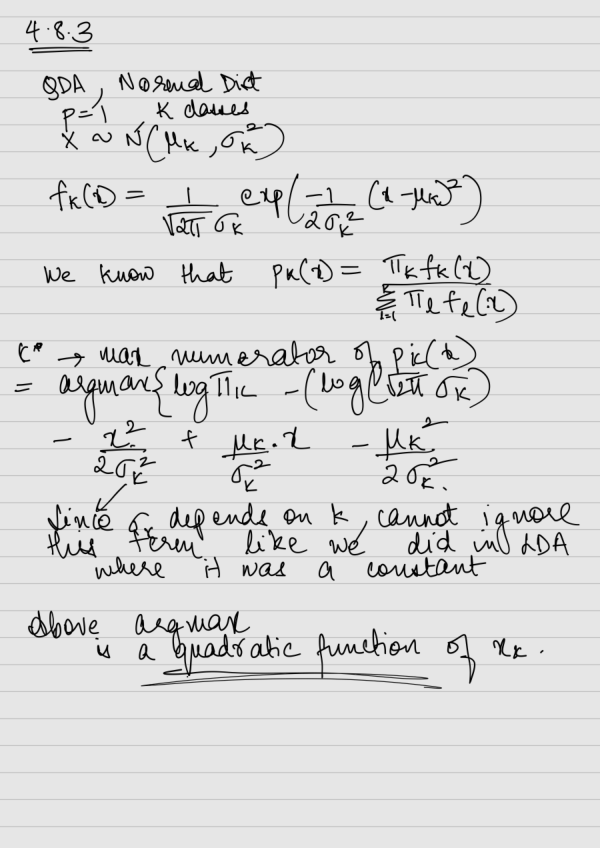

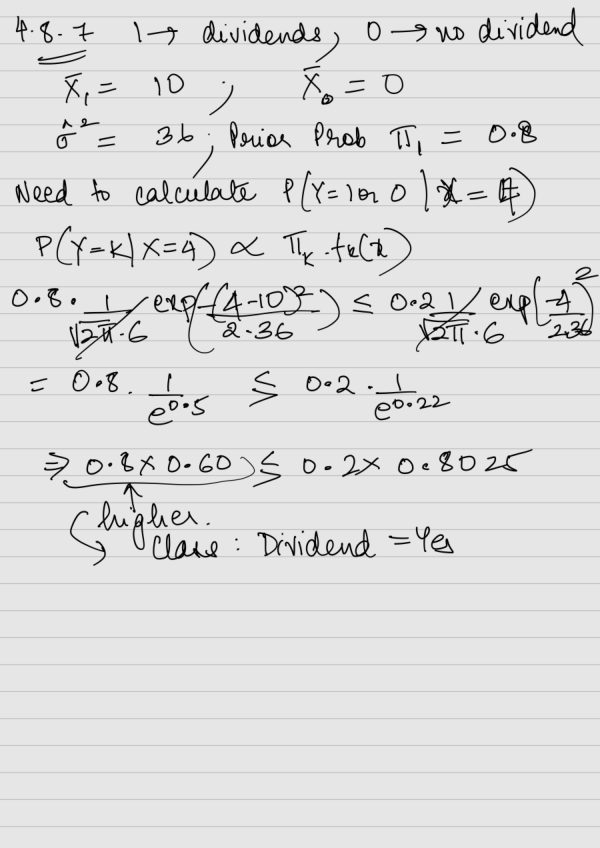

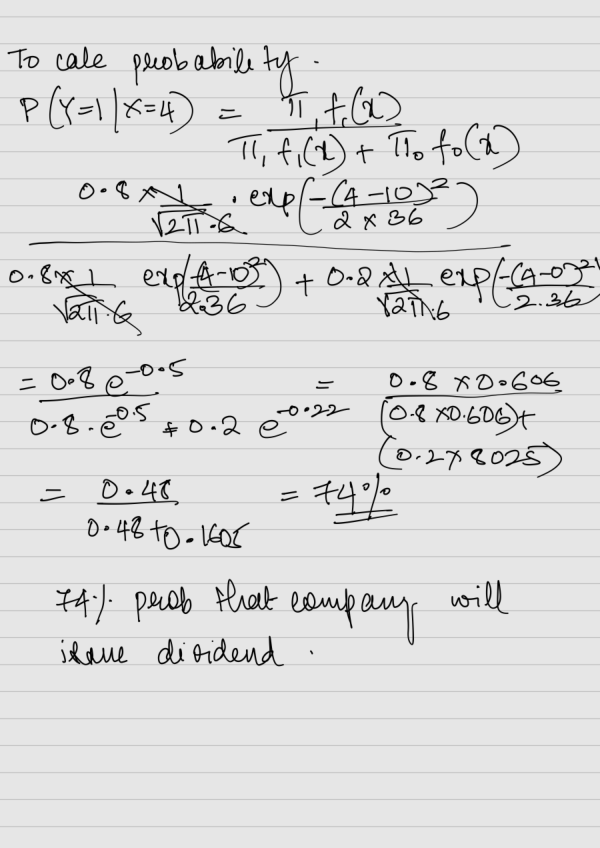

In [38]:
!pip install pymupdf
import fitz  # PyMuPDF
from IPython.display import display
from PIL import Image

def display_pdf_with_pymupdf(pdf_path):
    doc = fitz.open(pdf_path)
    for page_num in range(len(doc)):
        pix = doc[page_num].get_pixmap()
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        display(img)

pdf_file = "hw4_navya.pdf"
display_pdf_with_pymupdf(pdf_file)